In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

from spatial_split import *
from utils import *


24/05/28 20:17:02 WARN Utils: Your hostname, yaozys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.30.193.7 instead (on interface en0)
24/05/28 20:17:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/28 20:17:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/28 20:17:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 1. Load Data

In [2]:
from sklearn.datasets import make_blobs

# Generate random dataset with 3 dimensions
n_samples = 100  # Number of samples
n_features = 3  # Number of dimensions
centers = 10  # Number of clusters
random_state = 42  # Random state for reproducibility

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)
X = X.tolist()

# 2. Set parameter

In [9]:
# set parameters
min_pts = 5
eps = 2
n_features = len(X[0])
n_pa_each_dim = [3 for i in range(n_features)]


In [4]:
def get_point_index(data, value):
    return data.index(value)

# 3. Parallelize Data

In [7]:
rdd = sc.parallelize(X)

# min_pts = sc.broadcast(min_pts)
# eps = sc.broadcast(eps)
# n_pa_each_dim = sc.broadcast(n_pa_each_dim)
# n_features = sc.broadcast(n_features)


# 4. Construct grid cells and locate points into cell

In [10]:
# construct the grid
min_max_bounds = get_minmax_by_data(X)
n_grid_each_dim = cal_grid_num(min_max_bounds, eps)
grid_bin_bounds = get_bin_bounds(min_max_bounds, n_grid_each_dim)

# locate the points
grid_rdd = rdd.map(lambda x: (find_location_id(x, grid_bin_bounds, n_grid_each_dim), x))

# group the points inside each grid
grid_rdd = grid_rdd.groupByKey().mapValues(list)
grid_rdd.cache()
grid_rdd.take(10)

[((8, 14, 3),
  [[-0.290283109174704, 5.984511095595305, -6.629223876653399],
   [-0.4164968413960098, 5.902578923433743, -6.606741233991601],
   [-0.028998218638255913, 6.06053471382532, -6.69943395209346]]),
 ((8, 6, 11), [[-0.8460643599490254, -3.6616312451269524, 2.752105580753638]]),
 ((8, 11, 0),
  [[-0.025577988321223488, 2.1724577297292917, -9.201134799967729]]),
 ((15, 4, 2), [[8.545645798662383, -5.9986059024373475, -7.117236820215477]]),
 ((9, 13, 3), [[0.7538109882723547, 4.27337784989964, -6.446568843529789]]),
 ((2, 15, 10), [[-7.922925638933936, 7.652274025158388, 1.4925400310971368]]),
 ((1, 6, 6), [[-9.23526537361677, -3.970652714526209, -3.334549598894554]]),
 ((7, 17, 13), [[-1.8975213342118824, 10.045285650694272, 5.5711589553443]]),
 ((9, 11, 1),
  [[1.1842886437054831, 2.155590898117459, -8.258129626761084],
   [1.0319823733954943, 2.458661642674315, -9.091893339564193]]),
 ((5, 17, 11), [[-3.7300412730237724, 9.223149723203077, 2.6802087123483256]])]

In [11]:
grid_rdd.partitioner.partitionFunc

<function pyspark.rdd.portable_hash(x: Hashable) -> int>

# 5. Partition data

In [12]:
# allocate grid into partitions

def add_partition_id(x, grid_bins, n_pa_each_dim, buffer_size):
    buffer_loc_id = find_buffer_location_id(x[0], grid_bins, n_pa_each_dim, buffer_size)
    buffer_loc_id = list(set(buffer_loc_id))
    return [(blid, (x[0], x[1])) for blid in buffer_loc_id]

def get_partitioned_cells(rdd, grid_bins, n_pa_each_dim, buffer_size):
    rdd1 = rdd.flatMap(lambda x: add_partition_id(x, grid_bins, n_pa_each_dim, buffer_size))
    partitioned_rdd = rdd1.groupByKey().mapValues(list)
    # partitioned_rdd = rdd1.sortByKey()
    return partitioned_rdd

# divide the grid into partitions
grid_min_max = np.array(([0 for _ in range(len(n_grid_each_dim))], [i-1 for i in n_grid_each_dim])).T
grid_bins = get_bin_bounds(grid_min_max, n_pa_each_dim)

# buffer size (number of cells to be included in half of the buffer region)
buffer_size = int(np.ceil(eps/cal_grid_side_len(eps, n_features)))
partitioned_rdd = get_partitioned_cells(grid_rdd, grid_bins, n_pa_each_dim, buffer_size)
partitioned_rdd.glom().take(2)

[[((1, 0, 0),
   [((9, 13, 3), [[0.7538109882723547, 4.27337784989964, -6.446568843529789]]),
    ((10, 2, 2),
     [[1.4548994656670846, -7.688120794044457, -7.381866636860483]]),
    ((10, 3, 1),
     [[1.6741623334748645, -6.787866414615768, -8.867678507876839]]),
    ((9, 12, 3),
     [[1.254433058996986, 3.7514314283377708, -6.158309451868389]]),
    ((9, 3, 3),
     [[1.1339521607180933, -7.188839567002485, -6.548846161872382]]),
    ((10, 3, 4), [[1.75349779610322, -6.522514619639524, -5.40221554853443]]),
    ((4, 6, 5),
     [[-5.444668546678066, -3.752125318334681, -3.9336470884612114]]),
    ((9, 2, 3),
     [[0.8668347099347038, -8.075833815231942, -6.067583770881749]]),
    ((9, 12, 0),
     [[0.40201615158101456, 3.1259562730292747, -9.662563134435874]]),
    ((11, 3, 3),
     [[3.3294097125115547, -6.951637312731604, -5.876576695383923]]),
    ((11, 3, 4),
     [[3.511206250406701, -6.915453230261222, -5.315465937461941]]),
    ((10, 2, 3),
     [[2.334805708988366, -7.5

In [13]:
print("Partitioner: ",partitioned_rdd.partitioner.partitionFunc)
print("Partition number: ", partitioned_rdd.getNumPartitions())

Partitioner:  <function portable_hash at 0x7f97f9ac2290>
Partition number:  8


# 6. Identify Core Point

In [14]:
# find core points in each partition
def find_core_points(pa, eps, min_pts):
    pa = list(pa)
    for p in pa:
        pid = p[0]
        grids = p[1]
        
        points = []
        for grid in grids:
            for p in grid[1]:
                points.append([pid, grid[0], p])
                
        for pid, gid, value in points:
            count = 0
            core_flag = 0
            for _, _, value2 in points:
                if value == value2:
                    continue
                if np.linalg.norm(np.array(value) - np.array(value2)) <= eps:
                    count += 1
                    if count >= min_pts:
                        core_flag = 1
                        break
            yield ((pid, gid), value, core_flag)

points_with_flag = partitioned_rdd.mapPartitions(lambda x: find_core_points(x, eps, min_pts))
points_with_flag.take(10)


[(((1, 0, 0), (9, 13, 3)),
  [0.7538109882723547, 4.27337784989964, -6.446568843529789],
  0),
 (((1, 0, 0), (10, 2, 2)),
  [1.4548994656670846, -7.688120794044457, -7.381866636860483],
  1),
 (((1, 0, 0), (10, 3, 1)),
  [1.6741623334748645, -6.787866414615768, -8.867678507876839],
  0),
 (((1, 0, 0), (9, 12, 3)),
  [1.254433058996986, 3.7514314283377708, -6.158309451868389],
  0),
 (((1, 0, 0), (9, 3, 3)),
  [1.1339521607180933, -7.188839567002485, -6.548846161872382],
  1),
 (((1, 0, 0), (10, 3, 4)),
  [1.75349779610322, -6.522514619639524, -5.40221554853443],
  1),
 (((1, 0, 0), (4, 6, 5)),
  [-5.444668546678066, -3.752125318334681, -3.9336470884612114],
  0),
 (((1, 0, 0), (9, 2, 3)),
  [0.8668347099347038, -8.075833815231942, -6.067583770881749],
  0),
 (((1, 0, 0), (9, 12, 0)),
  [0.40201615158101456, 3.1259562730292747, -9.662563134435874],
  0),
 (((1, 0, 0), (11, 3, 3)),
  [3.3294097125115547, -6.951637312731604, -5.876576695383923],
  0)]

In [15]:
points_with_flag.partitioner

# 7. Find core cells

In [16]:
# find core cells with at least one core point in each partition

def find_core_cells(pa):
    pa = list(pa)
    core_cells = {}
    for key, point, flag in pa:
        if flag == 1:
            if key not in core_cells:
                core_cells[key] = []
            core_cells[key].append(point)
    for key in core_cells:
        yield ((key[0], key[1]), core_cells[key])
    
core_cells = points_with_flag.mapPartitions(lambda x: find_core_cells(x))
core_cells.take(10)


[(((1, 0, 0), (10, 2, 2)),
  [[1.4548994656670846, -7.688120794044457, -7.381866636860483]]),
 (((1, 0, 0), (9, 3, 3)),
  [[1.1339521607180933, -7.188839567002485, -6.548846161872382]]),
 (((1, 0, 0), (10, 3, 4)),
  [[1.75349779610322, -6.522514619639524, -5.40221554853443]]),
 (((1, 0, 0), (10, 2, 3)),
  [[2.334805708988366, -7.5247469457563945, -6.518713987767533]]),
 (((1, 0, 0), (11, 3, 2)),
  [[2.948714811063091, -7.35880142899656, -7.065768569939764]]),
 (((0, 0, 1), (2, 6, 9)),
  [[-7.402802300992436, -3.4326827255660604, 0.27166584731890636]]),
 (((0, 0, 1), (4, 6, 8)),
  [[-5.475511008607851, -3.7010613966790418, -0.7506101460672308]]),
 (((0, 0, 1), (3, 7, 9)),
  [[-6.318907911053417, -2.4616210636519287, 0.23047179940680118]]),
 (((0, 0, 1), (3, 6, 8)),
  [[-6.178184696985796, -3.8569464223632455, -0.6478416651858658],
   [-6.158728877080142, -3.5298377610804086, -0.38872880355637573]]),
 (((0, 0, 1), (4, 6, 9)),
  [[-5.617909308839232, -3.4419175162357005, 0.422299719987884

In [17]:
# adopted to avoid shuffling (reduceByKey)

# core_cells = points_with_flag.map(lambda x: (x[0], x[2]))\
#                               .reduceByKey(lambda x, y: x+y)\
#                                 .filter(lambda x: x[1] > 0)
# core_cells.take(10)

# 8. Find eps-neighbor cell pair

In [18]:
def get_distance_matrix(points1, points2):
    distance_matrix = np.zeros((len(points1), len(points2)))
    for i in range(len(points1)):
        for j in range(len(points2)):
            distance_matrix[i][j] = np.linalg.norm(np.array(points1[i]) - np.array(points2[j]))
    return distance_matrix

def find_neighbor_cell(pa, eps):
    pa = list(pa)
    partitions = {}
    
    for (paid, gid), points in pa:
        if paid not in partitions:
            partitions[paid] = []
        partitions[paid].append((gid, points))
    
    for pid, grids in partitions.items():
        for i, (gid, points) in enumerate(grids):
            for gid2, points2 in grids[i+1:]:
                distance_matrix = get_distance_matrix(points, points2)
                isNeighbor = np.sum(distance_matrix <= eps)
                if isNeighbor >= 1:
                    yield (pid, gid, gid2)

neighbor_pairs = core_cells.mapPartitions(lambda x: find_neighbor_cell(x, eps))
neighbor_pairs.collect()

[((1, 0, 0), (10, 2, 2), (9, 3, 3)),
 ((1, 0, 0), (10, 2, 2), (10, 2, 3)),
 ((1, 0, 0), (10, 2, 2), (11, 3, 2)),
 ((1, 0, 0), (9, 3, 3), (10, 3, 4)),
 ((1, 0, 0), (9, 3, 3), (10, 2, 3)),
 ((1, 0, 0), (9, 3, 3), (11, 3, 2)),
 ((1, 0, 0), (10, 3, 4), (10, 2, 3)),
 ((1, 0, 0), (10, 2, 3), (11, 3, 2)),
 ((0, 0, 1), (2, 6, 9), (3, 7, 9)),
 ((0, 0, 1), (2, 6, 9), (3, 6, 8)),
 ((0, 0, 1), (2, 6, 9), (4, 6, 9)),
 ((0, 0, 1), (4, 6, 8), (3, 7, 9)),
 ((0, 0, 1), (4, 6, 8), (3, 6, 8)),
 ((0, 0, 1), (4, 6, 8), (4, 6, 9)),
 ((0, 0, 1), (3, 7, 9), (3, 6, 8)),
 ((0, 0, 1), (3, 7, 9), (4, 6, 9)),
 ((0, 0, 1), (3, 6, 8), (4, 6, 9)),
 ((1, 2, 2), (5, 16, 12), (5, 17, 12)),
 ((1, 2, 2), (5, 16, 12), (6, 16, 13)),
 ((1, 2, 2), (5, 16, 12), (7, 16, 12)),
 ((1, 2, 2), (5, 16, 12), (6, 17, 12)),
 ((1, 2, 2), (5, 16, 12), (5, 17, 13)),
 ((1, 2, 2), (5, 17, 12), (7, 16, 12)),
 ((1, 2, 2), (5, 17, 12), (6, 17, 12)),
 ((1, 2, 2), (5, 17, 12), (5, 17, 13)),
 ((1, 2, 2), (6, 16, 13), (7, 16, 12)),
 ((1, 2, 2), (6,

# 9. Create a graph

In [19]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame
spark = SparkSession.builder.appName("ApproxDBSCAN").getOrCreate()


In [20]:
# dict to store the mapping between tuple index and integer index
# transform the index before using graphframes

pos_to_gid, gid_to_pos = grid_index_mapping(n_grid_each_dim)
pos_to_paid, paid_to_pos = grid_index_mapping(n_pa_each_dim)

In [21]:
# create vertices and edges

v = core_cells.map(lambda x: (pos_to_paid[x[0][0]], pos_to_gid[x[0][1]],)).toDF(["paid", "id"])
v = v.repartition(int(np.prod(n_pa_each_dim)), "paid")
e = neighbor_pairs.map(lambda x: (pos_to_paid[x[0]], pos_to_gid[x[1]], pos_to_gid[x[2]])).toDF(["paid", "src", "dst"])
e = e.repartition(int(np.prod(n_pa_each_dim)), "paid")

# create graph
g = GraphFrame(v, e)
g.edges.show()

/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+----+----+----+
|paid| src| dst|
+----+----+----+
|  21|3115|3439|
|  21|3115|3096|
|  21|3115|3114|
|  21|3115|3132|
|  21|4611|4612|
|  21|4611|4287|
|  21|4611|4936|
|  21|3439|3096|
|  21|3439|3114|
|  21|3439|3132|
|  21|4612|4287|
|  21|4612|4936|
|  21|3096|3114|
|  21|3096|3132|
|  21|3114|3132|
|  21|4287|4936|
|  16|1920|1938|
|  16|1920|2568|
|  16|1920|2262|
|  16|1938|2568|
+----+----+----+
only showing top 20 rows



In [22]:
# set Checkpoint directory
sc.setCheckpointDir("checkpoints")

# compute connected components
# not optimal to use connectedComponents(), since it will shuffle the data and lose the partition.
# TODO: New implementation is required for computing connected component.
result = g.connectedComponents()
result.show()


/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----+----+---------+
|paid|  id|component|
+----+----+---------+
|  21|3115|     2790|
|  21|4611|     4269|
|  21|3439|     2790|
|  21|4612|     4269|
|  21|3096|     2790|
|  21|3114|     2790|
|  21|3132|     2790|
|  21|4287|     4269|
|  21|4936|     4269|
|  16|1920|     1920|
|  16|1938|     1920|
|  16|2568|     1920|
|  16|2262|     1920|
|  13|2386|     2386|
|  14|2386|     2386|
|   4| 765|      765|
|   4|1412|      765|
|   4|1107|      765|
|   4|1088|      765|
|   4|1413|      765|
+----+----+---------+
only showing top 20 rows



In [23]:
points_with_flag.collect()

[(((1, 0, 0), (9, 13, 3)),
  [0.7538109882723547, 4.27337784989964, -6.446568843529789],
  0),
 (((1, 0, 0), (10, 2, 2)),
  [1.4548994656670846, -7.688120794044457, -7.381866636860483],
  1),
 (((1, 0, 0), (10, 3, 1)),
  [1.6741623334748645, -6.787866414615768, -8.867678507876839],
  0),
 (((1, 0, 0), (9, 12, 3)),
  [1.254433058996986, 3.7514314283377708, -6.158309451868389],
  0),
 (((1, 0, 0), (9, 3, 3)),
  [1.1339521607180933, -7.188839567002485, -6.548846161872382],
  1),
 (((1, 0, 0), (10, 3, 4)),
  [1.75349779610322, -6.522514619639524, -5.40221554853443],
  1),
 (((1, 0, 0), (4, 6, 5)),
  [-5.444668546678066, -3.752125318334681, -3.9336470884612114],
  0),
 (((1, 0, 0), (9, 2, 3)),
  [0.8668347099347038, -8.075833815231942, -6.067583770881749],
  0),
 (((1, 0, 0), (9, 12, 0)),
  [0.40201615158101456, 3.1259562730292747, -9.662563134435874],
  0),
 (((1, 0, 0), (11, 3, 3)),
  [3.3294097125115547, -6.951637312731604, -5.876576695383923],
  0),
 (((1, 0, 0), (11, 3, 4)),
  [3.51120

# 10. Merge 

In [54]:
# remove duplicates
result = result.dropDuplicates(['id'])

def remove_duplicates(x):
    gid = x[0]
    points = x[1]
    points_flag = {}
    for p in points:
        if p[0] not in points_flag:
            points_flag[p[0]] = p[1]
        else:
            if (p[1] == 1)&(points_flag[p[0]] == 0):
                points_flag[p[0]] = 1
    for k, v in points_flag.items():
        yield (gid, (k, v))
    # return (gid, [(k, v) for k, v in points_flag.items()])
                

points_flagged = points_with_flag.map(lambda x: (pos_to_gid[x[0][1]], (get_point_index(X, x[1]), x[2])))
points_flagged = points_flagged.groupByKey().mapValues(list)
points_flagged = points_flagged.flatMap(lambda x: remove_duplicates(x))
points_flagged.collect()

[(728, (23, 0)),
 (1736, (62, 0)),
 (1376, (33, 0)),
 (1088, (91, 1)),
 (1088, (95, 1)),
 (744, (81, 1)),
 (1920, (78, 1)),
 (2568, (82, 1)),
 (3096, (80, 1)),
 (3096, (90, 1)),
 (624, (71, 0)),
 (4936, (38, 1)),
 (2864, (9, 1)),
 (2864, (13, 1)),
 (3616, (67, 0)),
 (4552, (1, 0)),
 (4952, (77, 0)),
 (4304, (58, 0)),
 (928, (30, 1)),
 (280, (20, 0)),
 (280, (68, 0)),
 (3153, (17, 0)),
 (1409, (85, 0)),
 (1105, (83, 0)),
 (1937, (57, 0)),
 (2585, (65, 0)),
 (3921, (66, 0)),
 (3905, (54, 0)),
 (3905, (56, 0)),
 (929, (63, 0)),
 (3298, (53, 1)),
 (2370, (64, 0)),
 (1090, (44, 0)),
 (1938, (37, 1)),
 (3114, (93, 1)),
 (3170, (73, 1)),
 (2386, (2, 1)),
 (2386, (10, 0)),
 (3922, (29, 1)),
 (2955, (76, 0)),
 (2667, (79, 0)),
 (1107, (25, 1)),
 (763, (36, 0)),
 (2587, (49, 0)),
 (1939, (88, 1)),
 (3115, (51, 1)),
 (3115, (74, 1)),
 (3923, (75, 0)),
 (3939, (94, 0)),
 (4611, (92, 1)),
 (4323, (52, 0)),
 (603, (48, 1)),
 (603, (59, 0)),
 (3132, (35, 1)),
 (3620, (27, 1)),
 (1412, (31, 1)),
 (106

In [46]:
len(set(points_flagged.keys().collect()))

86

# 11. Assign points to clusters

In [62]:
cluster = result.rdd.map(lambda x: (x[1], x[2]))\
                        .join(points_flagged)\
                        .map(lambda x: (x[1][0], x[1][1][0], x[1][1][1]))
cluster_df = cluster.toDF(["cluster_id", "point_id", "core_flag"])
cluster_df.show()


+----------+--------+---------+
|cluster_id|point_id|core_flag|
+----------+--------+---------+
|      2790|      93|        1|
|      2790|      35|        1|
|      2790|      80|        1|
|      2790|      90|        1|
|       765|      25|        1|
|       765|      98|        1|
|       765|      47|        1|
|       603|      48|        1|
|       603|      59|        0|
|      2790|       5|        1|
|      2790|      51|        1|
|      2790|      74|        1|
|      2790|      22|        1|
|      2790|      26|        1|
|      2386|       2|        1|
|      2386|      10|        0|
|       603|      42|        1|
|       603|      97|        1|
|       603|      30|        1|
|      2973|      41|        1|
+----------+--------+---------+
only showing top 20 rows



# 12. Evaluation

In [64]:
# cluster_df to pandas dataframe
import pandas as pd

df = pd.DataFrame(list(range(len(X))), columns=["point_id"])
df.head()

,point_id
0,0
1,1
2,2
3,3
4,4


In [67]:
result = df.merge(cluster_df.toPandas(), on="point_id", how="left")
result = result.fillna(-1)
result.head()

,point_id,cluster_id,core_flag
0,0,2829.0,1.0
1,1,-1.0,-1.0
2,2,2386.0,1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


In [68]:
# dbscan from sklearn
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=eps, min_samples=min_pts)
dbscan.fit(X)
result["sklearn_cluster"] = dbscan.labels_
result.head()

,point_id,cluster_id,core_flag,sklearn_cluster
0,0,2829.0,1.0,0
1,1,-1.0,-1.0,-1
2,2,2386.0,1.0,1
3,3,-1.0,-1.0,1
4,4,-1.0,-1.0,9


In [69]:
# clustering evaluation metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

adjusted_rand_score(result["sklearn_cluster"], result["cluster_id"])


0.17425381790315728

In [70]:
adjusted_mutual_info_score(result["sklearn_cluster"], result["cluster_id"])

0.46648156235403093

In [71]:
silhouette_score(X, result["cluster_id"])

-0.07282759087495277

In [72]:
silhouette_score(X, result["sklearn_cluster"])

0.45579730648402467

# 13. visualization

In [76]:
list(result["cluster_id"])

[2829.0,
 -1.0,
 2386.0,
 -1.0,
 -1.0,
 2790.0,
 2829.0,
 -1.0,
 -1.0,
 2829.0,
 2386.0,
 2829.0,
 -1.0,
 2829.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 2973.0,
 -1.0,
 -1.0,
 2790.0,
 -1.0,
 2973.0,
 765.0,
 2790.0,
 2973.0,
 4269.0,
 3922.0,
 603.0,
 765.0,
 -1.0,
 -1.0,
 4269.0,
 2790.0,
 -1.0,
 1920.0,
 4269.0,
 -1.0,
 4269.0,
 2973.0,
 603.0,
 -1.0,
 -1.0,
 1920.0,
 -1.0,
 765.0,
 603.0,
 -1.0,
 -1.0,
 2790.0,
 -1.0,
 2973.0,
 -1.0,
 1920.0,
 -1.0,
 -1.0,
 -1.0,
 603.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 2829.0,
 -1.0,
 -1.0,
 4269.0,
 2829.0,
 2790.0,
 -1.0,
 -1.0,
 -1.0,
 1920.0,
 -1.0,
 2790.0,
 744.0,
 1920.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1920.0,
 -1.0,
 2790.0,
 765.0,
 4269.0,
 2790.0,
 -1.0,
 765.0,
 2973.0,
 603.0,
 765.0,
 2829.0]

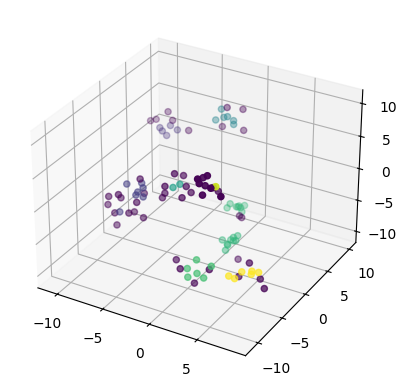

In [81]:
# visualization of the clustering result
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.array(X)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=result["cluster_id"].astype(int))
plt.show()
